# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
model_name = "mono+stereo_1024x320"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

-> Downloading pretrained model to models\mono+stereo_1024x320.zip
   Unzipping model...
   Model unzipped to models\mono+stereo_1024x320


## Loading the test image and preprocessing

In [5]:
import cv2

kaggle_image = cv2.imread("D:/monodepth2/pku-autonomous-driving/train_images/ID_00ab59fa6.jpg")
kaggle_mask = cv2.imread("D:/monodepth2/pku-autonomous-driving/train_masks/ID_00ab59fa6.jpg")

In [6]:
masked_image = (kaggle_image * (kaggle_mask == 0))
masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
masked_image.shape

(2710, 3384, 3)

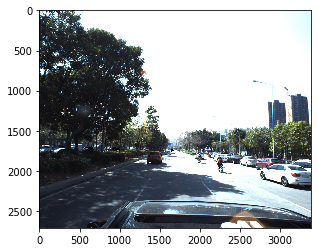

In [7]:
plt.figure()
plt.imshow(masked_image)
plt.show()

In [8]:
original_width, original_height, _ = masked_image.shape

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = cv2.resize(masked_image, (feed_width, feed_height))

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
input_image_pytorch.shape

torch.Size([1, 3, 320, 1024])

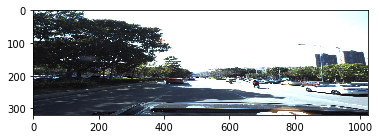

In [9]:
plt.figure()
plt.imshow(input_image_resized)
plt.show()

In [10]:
# image_path = "assets/test_image.jpg"

# input_image = pil.open(image_path).convert('RGB')
# original_width, original_height = input_image.size

# feed_height = loaded_dict_enc['height']
# feed_width = loaded_dict_enc['width']
# input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

# input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
# input_image_pytorch.shape

## Prediction using the PyTorch model

In [11]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

In [12]:
for i in range(len(features)):
    print(i, features[i].shape)

0 torch.Size([1, 64, 160, 512])
1 torch.Size([1, 64, 80, 256])
2 torch.Size([1, 128, 40, 128])
3 torch.Size([1, 256, 20, 64])
4 torch.Size([1, 512, 10, 32])


In [13]:
for key in list(outputs.keys()):
    print(key, outputs[key].shape)

('disp', 3) torch.Size([1, 1, 40, 128])
('disp', 2) torch.Size([1, 1, 80, 256])
('disp', 1) torch.Size([1, 1, 160, 512])
('disp', 0) torch.Size([1, 1, 320, 1024])


In [19]:
disp.squeeze().max()

tensor(0.1067)

## Plotting

(2710, 3384)


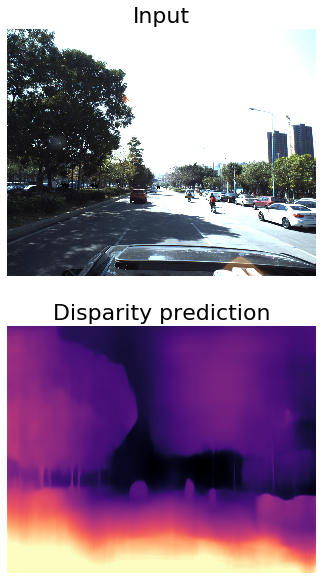

In [14]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_width, original_height), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
print(disp_resized_np.shape)
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(masked_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

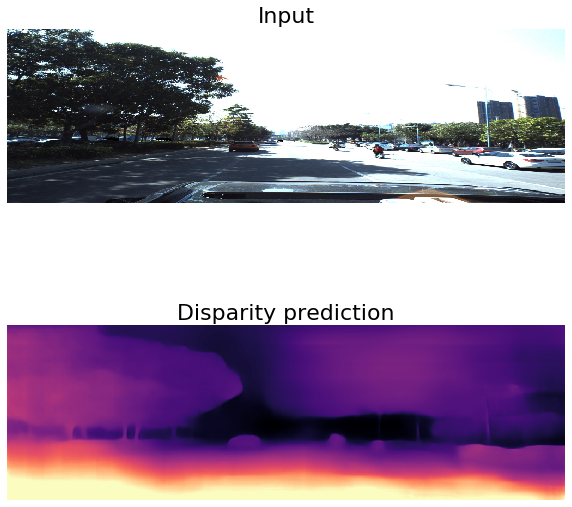

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image_resized)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp.squeeze().cpu().numpy(), cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [20]:
disp.squeeze().cpu().numpy()

array([[0.02617322, 0.0262064 , 0.02603496, ..., 0.02153169, 0.02162432,
        0.0217758 ],
       [0.02602736, 0.02602622, 0.02590608, ..., 0.02140565, 0.02150419,
        0.02163801],
       [0.02671685, 0.02674187, 0.02658188, ..., 0.02140541, 0.02152542,
        0.02165289],
       ...,
       [0.10617646, 0.10474557, 0.10408475, ..., 0.07870461, 0.07952889,
        0.08054636],
       [0.10651575, 0.1051333 , 0.10442148, ..., 0.07916344, 0.07999979,
        0.08100598],
       [0.10671639, 0.10532822, 0.10454514, ..., 0.07962366, 0.08047592,
        0.08148574]], dtype=float32)

In [22]:
import pandas as pd

In [24]:
train_data = pd.read_csv('D:/monodepth2/pku-autonomous-driving/train.csv')

In [31]:
for i in range(train_data.shape[0]):
    print()

(4262, 2)